# Домашние задание №3. Работа с моделью UserKNN

In [1]:
!pip install rectools

In [2]:
!pip install implicit

In [3]:
%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pprint import pprint
from copy import deepcopy

from tqdm.auto import tqdm
import pickle
import json

from rectools import Columns
from rectools.model_selection import TimeRangeSplitter
from rectools.dataset import Dataset, Interactions
from rectools.metrics.classification import Precision, Recall
from rectools.metrics.ranking import MAP
from rectools.metrics.novelty import MeanInvUserFreq
from rectools.metrics.serendipity import Serendipity
from rectools.metrics import calc_metrics
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender

from userknn import UserKnn
from most_popular import MostPopular

## Работа с данными

### Загрузка данных

In [5]:
data_dir_path = '/content/drive/MyDrive/recsys_course/data_kion'

data_interactions = pd.read_csv(f'{data_dir_path}/interactions.csv', parse_dates=['last_watch_dt'])

data_interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    },
    inplace=True)

print(data_interactions.shape)
data_interactions.head()

(5476251, 5)


,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
data_items = pd.read_csv(f'{data_dir_path}/items.csv')

print(data_items.shape)
data_items.head()

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [7]:
data_users = pd.read_csv(f'{data_dir_path}/users.csv')

print(data_users.shape)
data_users.head()

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


### Проведем небольшое EDA, чтобы выбрать оптимальный временной промежуток для валидации

In [ ]:
data_interactions[Columns.Datetime].min(), data_interactions[Columns.Datetime].max()

(Timestamp('2021-03-13 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [ ]:
daily_inters = data_interactions.groupby(Columns.Datetime)[Columns.User].agg('count')
daily_inters.name = 'interactions'
daily_inters.head(10)

datetime
2021-03-13    16104
2021-03-14    15606
2021-03-15    12363
2021-03-16    12643
2021-03-17    12753
2021-03-18    12788
2021-03-19    13657
2021-03-20    15346
2021-03-21    15560
2021-03-22    12752
Name: interactions, dtype: int64

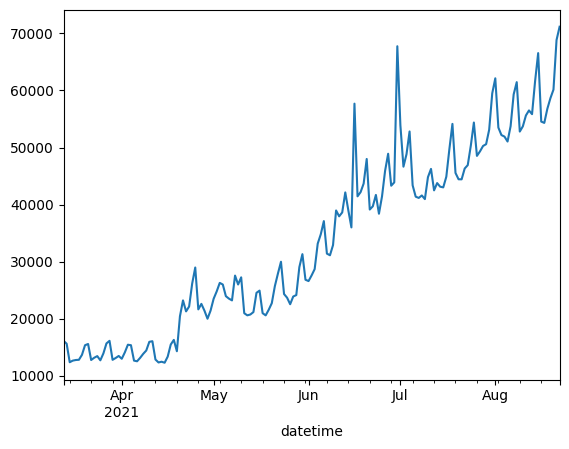

In [ ]:
daily_inters.plot()
plt.show()

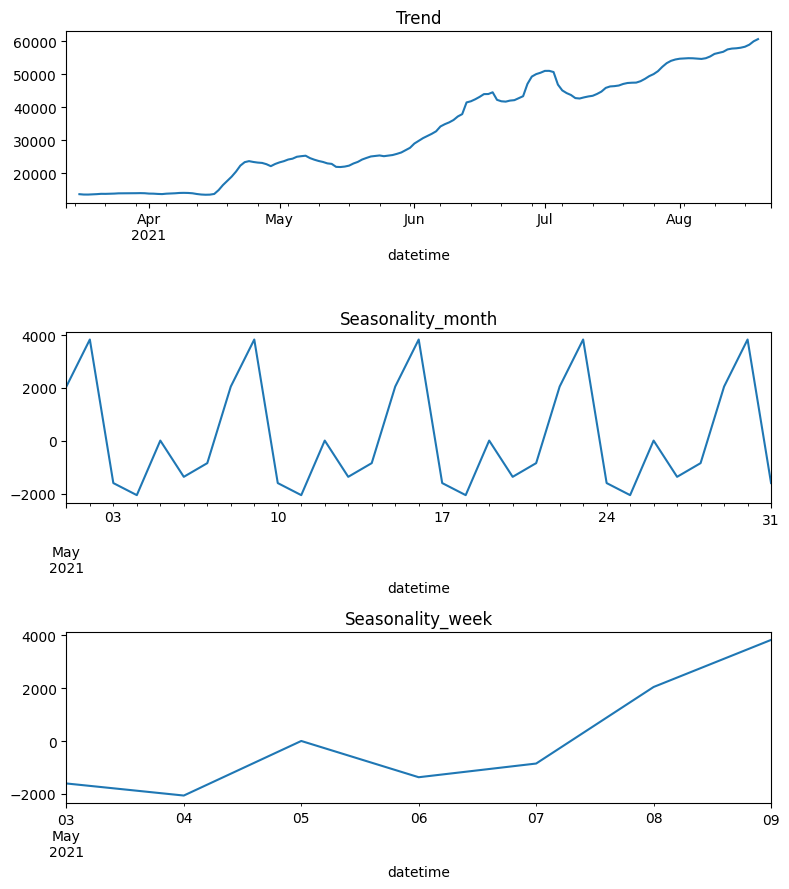

In [ ]:
decomposed = seasonal_decompose(daily_inters)

plt.figure(figsize=(8, 9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2021-05-01':'2021-05-31'].plot(ax=plt.gca())
plt.title('Seasonality_month')
plt.subplot(313)
decomposed.seasonal['2021-05-03':'2021-05-09'].plot(ax=plt.gca())
plt.title('Seasonality_week')
plt.tight_layout()

На графиках сезонности в течение месяца и недели видна определенная закономерность: к выходным кол-во просмотров повышается, а в начале недели вновь падает. Это выделяет неделю как пределенный тренд и период, который можно выделить в данных. Поэтому можно будет попробовать взять в тест, например, 2 недели: это не сломает тренд и даст нам больше данных для тестирования, что повысит его надежность.

### Разбиение датасета для кросс-валидации

- Сделаем 5 флодов для кросс-валидации по 2 недели каждый с исключением "холодных" юзеров и айтемов и просмотренных айтемов, так как мы ищем лучшие параметры именно для UserKNN, которая работает только для "горячих" пользователей.
- Так как кросс-валидация на всем датасете скорее всего займет много времени для ускорения процесса частично обрежем датасет начиная с 15.05.2021, чтобы в последнем фолде на трейн остался допустимый минимум данных - 1 месяц (это в 2 раза больше, чем тест в фолде).

In [ ]:
# оптимизируем датафрейм cv_data_interactions для дальнейшей подачи в splitter
cv_data_interactions = data_interactions[data_interactions['datetime'] >= '2021-05-11'].copy(deep=True)
print(cv_data_interactions[Columns.Datetime].min())
interactions = Interactions(cv_data_interactions)
interactions.df.head()

2021-05-11 00:00:00


,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
3,864613,7638,2021-07-05,14483.0,100.0
5,1032142,6686,2021-05-13,11286.0,100.0
6,1016458,354,2021-08-14,1672.0,25.0


In [ ]:
splitter = TimeRangeSplitter("14D", 5)

In [ ]:
splitter.get_test_fold_borders(interactions)

[(Timestamp('2021-06-14 00:00:00', freq='14D'),
  Timestamp('2021-06-28 00:00:00', freq='14D')),
 (Timestamp('2021-06-28 00:00:00', freq='14D'),
  Timestamp('2021-07-12 00:00:00', freq='14D')),
 (Timestamp('2021-07-12 00:00:00', freq='14D'),
  Timestamp('2021-07-26 00:00:00', freq='14D')),
 (Timestamp('2021-07-26 00:00:00', freq='14D'),
  Timestamp('2021-08-09 00:00:00', freq='14D')),
 (Timestamp('2021-08-09 00:00:00', freq='14D'),
  Timestamp('2021-08-23 00:00:00', freq='14D'))]

## Кросс-валидация UserKNN

In [ ]:
# возьмем три модели для тестирования различных метрик
models = {
    "userknn_cosine": CosineRecommender,
    "userknn_tfidf": TFIDFRecommender,
    "userknn_bm25": BM25Recommender,
}

# так же будем перебирать кол-во возвращаемых похожих юзеров при инициализации модели
n_users = {
    "k20": 20,
    "k30": 30,
}

# будем расчитывать следующие метрик
metrics = {
    "precision@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "map@10": MAP(k=10),
    "novelty@10": MeanInvUserFreq(k=10),
    "serendipity@10": Serendipity(k=10)
}

K_RECOS = 10

In [ ]:
# функция для кросс-валидации
# для каждого фолда разделяем датасет на train/test
# затем обучаем модели, выдаем рекомендации и считаем метрики
def userknn_cross_validate(models, n_users, metrics, interactions, splitter, k_recos):
  results = []

  fold_iterator = splitter.split(interactions, collect_fold_stats=True)

  for train_ids, test_ids, fold_info in tqdm((fold_iterator), total=5):
      print(f"\n==================== Fold {fold_info['i_split']}")
      pprint(fold_info)

      df_train = interactions.df.iloc[train_ids]
      df_test = interactions.df.iloc[test_ids][Columns.UserItem]

      catalog = df_train[Columns.Item].unique()

      for model_name, model in models.items():
        for n_users_flag, n_user in n_users.items():
          print(f"\n==== Recommender: {model_name}, K_sim_users: {n_user}")
          userknn_model = UserKnn(model=model(K=n_user), N_users=10)
          userknn_model = deepcopy(userknn_model)
          userknn_model.fit(df_train)
          recos = userknn_model.predict(df_test)
          metric_values = calc_metrics(
              metrics,
              reco=recos,
              interactions=df_test,
              prev_interactions=df_train,
              catalog=catalog,
          )
          res = {"fold": fold_info["i_split"], "model": model_name}
          res.update(metric_values)
          results.append(res)
  return results

In [ ]:
%%time

cv_results = userknn_cross_validate(models, n_users, metrics, interactions, splitter, K_RECOS)

  0%|          | 0/5 [00:00<?, ?it/s]


==================== Fold 0
{'end': Timestamp('2021-06-28 00:00:00', freq='14D'),
 'i_split': 0,
 'start': Timestamp('2021-06-14 00:00:00', freq='14D'),
 'test': 322905,
 'test_items': 6263,
 'test_users': 98468,
 'train': 948862,
 'train_items': 9366,
 'train_users': 278217}

==== Recommender: userknn_cosine, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.06777429580688477 seconds
  warnings.warn(


  0%|          | 0/278217 [00:00<?, ?it/s]


==== Recommender: userknn_cosine, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.06728172302246094 seconds
  warnings.warn(


  0%|          | 0/278217 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.10364413261413574 seconds
  warnings.warn(


  0%|          | 0/278217 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.06559443473815918 seconds
  warnings.warn(


  0%|          | 0/278217 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.06498885154724121 seconds
  warnings.warn(


  0%|          | 0/278217 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.08474540710449219 seconds
  warnings.warn(


  0%|          | 0/278217 [00:00<?, ?it/s]


==================== Fold 1
{'end': Timestamp('2021-07-12 00:00:00', freq='14D'),
 'i_split': 1,
 'start': Timestamp('2021-06-28 00:00:00', freq='14D'),
 'test': 378196,
 'test_items': 6627,
 'test_users': 123495,
 'train': 1551927,
 'train_items': 10283,
 'train_users': 395105}

==== Recommender: userknn_cosine, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.11801910400390625 seconds
  warnings.warn(


  0%|          | 0/395105 [00:00<?, ?it/s]


==== Recommender: userknn_cosine, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.14555978775024414 seconds
  warnings.warn(


  0%|          | 0/395105 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.11702704429626465 seconds
  warnings.warn(


  0%|          | 0/395105 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.11446857452392578 seconds
  warnings.warn(


  0%|          | 0/395105 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.11459612846374512 seconds
  warnings.warn(


  0%|          | 0/395105 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.11349296569824219 seconds
  warnings.warn(


  0%|          | 0/395105 [00:00<?, ?it/s]


==================== Fold 2
{'end': Timestamp('2021-07-26 00:00:00', freq='14D'),
 'i_split': 2,
 'start': Timestamp('2021-07-12 00:00:00', freq='14D'),
 'test': 385101,
 'test_items': 7139,
 'test_users': 116307,
 'train': 2208563,
 'train_items': 11257,
 'train_users': 506153}

==== Recommender: userknn_cosine, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.17122220993041992 seconds
  warnings.warn(


  0%|          | 0/506153 [00:00<?, ?it/s]


==== Recommender: userknn_cosine, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.21624517440795898 seconds
  warnings.warn(


  0%|          | 0/506153 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.17146515846252441 seconds
  warnings.warn(


  0%|          | 0/506153 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.18134474754333496 seconds
  warnings.warn(


  0%|          | 0/506153 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.24085450172424316 seconds
  warnings.warn(


  0%|          | 0/506153 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.2097303867340088 seconds
  warnings.warn(


  0%|          | 0/506153 [00:00<?, ?it/s]


==================== Fold 3
{'end': Timestamp('2021-08-09 00:00:00', freq='14D'),
 'i_split': 3,
 'start': Timestamp('2021-07-26 00:00:00', freq='14D'),
 'test': 447260,
 'test_items': 7513,
 'test_users': 130344,
 'train': 2861996,
 'train_items': 11862,
 'train_users': 608246}

==== Recommender: userknn_cosine, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.25055456161499023 seconds
  warnings.warn(


  0%|          | 0/608246 [00:00<?, ?it/s]


==== Recommender: userknn_cosine, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.28838491439819336 seconds
  warnings.warn(


  0%|          | 0/608246 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.30033040046691895 seconds
  warnings.warn(


  0%|          | 0/608246 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.22710967063903809 seconds
  warnings.warn(


  0%|          | 0/608246 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.22561407089233398 seconds
  warnings.warn(


  0%|          | 0/608246 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.23090505599975586 seconds
  warnings.warn(


  0%|          | 0/608246 [00:00<?, ?it/s]


==================== Fold 4
{'end': Timestamp('2021-08-23 00:00:00', freq='14D'),
 'i_split': 4,
 'start': Timestamp('2021-08-09 00:00:00', freq='14D'),
 'test': 511505,
 'test_items': 7551,
 'test_users': 147084,
 'train': 3618600,
 'train_items': 12400,
 'train_users': 721889}

==== Recommender: userknn_cosine, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.2964808940887451 seconds
  warnings.warn(


  0%|          | 0/721889 [00:00<?, ?it/s]


==== Recommender: userknn_cosine, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.3606271743774414 seconds
  warnings.warn(


  0%|          | 0/721889 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.31069207191467285 seconds
  warnings.warn(


  0%|          | 0/721889 [00:00<?, ?it/s]


==== Recommender: userknn_tfidf, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.2857046127319336 seconds
  warnings.warn(


  0%|          | 0/721889 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 20


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.2909431457519531 seconds
  warnings.warn(


  0%|          | 0/721889 [00:00<?, ?it/s]


==== Recommender: userknn_bm25, K_sim_users: 30


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.30729222297668457 seconds
  warnings.warn(


  0%|          | 0/721889 [00:00<?, ?it/s]

CPU times: user 9h 32min 14s, sys: 3min 40s, total: 9h 35min 54s
Wall time: 6h 47min 12s


In [ ]:
# добавим столбец, отражающий кол-во возвращаемых похожих юзеров при инициализации модели
# забыла добавлять его сразу во время валидации
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.loc[cv_results_df.index % 2 == 0, 'K_users'] = 20
cv_results_df['K_users'] = cv_results_df['K_users'].fillna(30)

In [ ]:
# усредняем метрики по фолдам
pivot_results = cv_results_df.drop(columns="fold").groupby(["model", "K_users"], sort=False).agg(["mean"])
mean_metric_subset = [(metric, agg) for metric, agg in pivot_results.columns if agg == 'mean']
(
    pivot_results.style
    .highlight_min(subset=mean_metric_subset, color='lightcoral', axis=0)
    .highlight_max(subset=mean_metric_subset, color='lightgreen', axis=0)
)

**Вывод:**

По итогам кросс-валидации можно сказать, что наиболее точной моделью является TFIDFRecommender. Хотя beyond-accuracy метрики у BM25Recommender модели выше, для нас сейчас важнее более точные рекомендации, поэтому в сервисе будем использовать TFIDFRecommender.

Кроме того, кросс-валидация показала, что изначально брать более 20 соседей из модели нет смысла, так как это не слишком влияет на метрики.

Также в сервисе будут добавлены популярные рекомендации для "холодных" пользователей и пользователей, для которых knn не выдала нужное кол-во рекомендаций, что должно значительно улучшить качество.

P.S. уменьшение датасета выигрыша по времени в итоге не дало, но останавливать процесс на середине я уже не стала

## Обучение модели UserKNN на всем датасете

In [18]:
MODELS_PATH = "/content/drive/MyDrive/recsys_course/models"
RECOS_PATH = "/content/drive/MyDrive/recsys_course/recommendations"

In [ ]:
%%time

userknn_model = UserKnn(model=TFIDFRecommender(K=20), N_users=20)
userknn_model.fit(data_interactions)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.4939587116241455 seconds
  warnings.warn(


  0%|          | 0/962179 [00:00<?, ?it/s]

CPU times: user 1h 26min 30s, sys: 25 s, total: 1h 26min 55s
Wall time: 58min 9s


In [ ]:
pickle.dump(userknn_model, open(f"{MODELS_PATH}/user_knn.pkl", "wb"))

In [9]:
# проверим, что обученная модель выдает рекомендации
pickled_model = pickle.load(open(f"{MODELS_PATH}/user_knn.pkl", "rb"))
pickled_model.recommend(864613)

[7638, 7189, 4260, 13668, 6006, 7476, 12192, 4151, 15297, 10440]

In [14]:
# сделаем рекомендации для всех пользователей
%%time

recos = pickled_model.predict(data_interactions)
user_knn_recos = recos.groupby("user_id")["item_id"].agg(list).to_dict()

CPU times: user 10min 24s, sys: 38.1 s, total: 11min 2s
Wall time: 11min 5s


In [19]:
# сохраним рекомендации
with open(f"{RECOS_PATH}/user_knn_recos.json", "w") as f:
    json.dump(user_knn_recos, f)

## Обучение модели PopularModel для рекомендаций "холодным" пользователям

MostPopular – это дополнительная "обертка" для PopularModel из rectools, чтобы можно было затем использовать ее в сервисе и она выдавала рекомендации в виде списка.

In [8]:
%%time

popular_model = MostPopular()
popular_model.fit(data_interactions)

CPU times: user 6.2 s, sys: 560 ms, total: 6.76 s
Wall time: 10.3 s


In [11]:
pickle.dump(popular_model, open(f"{MODELS_PATH}/popular.pkl", "wb"))

In [20]:
# проверим, что обученная модель выдает рекомендации
pickled_model = pickle.load(open(f"{MODELS_PATH}/popular.pkl", "rb"))
pickled_model.recommend()

[10440, 15297, 9728, 13865, 4151, 3734, 2657, 4880, 142, 6809]

In [32]:
popular_recos = {}
popular_recos['popular_recos'] = [int(reco) for reco in pickled_model.recommend()]

In [33]:
# сохраним рекомендации
with open(f"{RECOS_PATH}/popular_recos.json", "w") as f:
    json.dump(popular_recos, f)

Теперь данную модель можно использовать в сервисе для "холодных" пользователей. Она будет выдавать им айтемы,которые популярны во всем доступном датасете.